In [ ]:
import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from google.colab import drive
import time


In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
print(torch.__version__)

2.1.0+cu118


UsageError: Line magic function `%python3` not found (But cell magic `%%python3` exists, did you mean that instead?).


In [ ]:
import platform
print(platform.python_version())

3.10.12


In [ ]:
data_path = "/content/drive/MyDrive/machine_learning_project/data/"

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224)),  transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])
train_data = datasets.ImageFolder(root=data_path+"/TRAIN/", transform=transform)
test_data = datasets.ImageFolder(root=data_path+"/TEST/", transform=transform)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


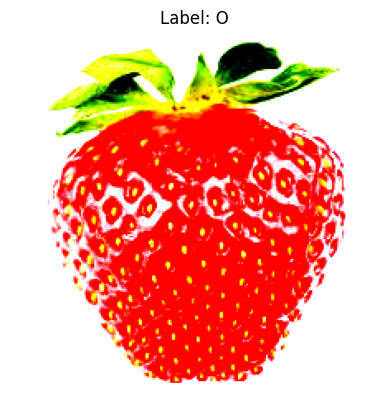

In [ ]:
image = train_data[0][0]
label = train_data[0][1]
image_np = image.permute(1,2,0).numpy()
plt.imshow(image_np)
plt.title(f"Label: {train_data.classes[label]}")
plt.axis('off')
plt.show()

In [ ]:
num_classes = len(train_data.classes)
class_names = train_data.classes
print("Number of classes: ", num_classes)
print("Class names: ", class_names)

Number of classes:  2
Class names:  ['O', 'R']


In [ ]:
#Check for datasize
print("Train data size: ", len(train_data))
print("Test data size: ", len(test_data))


Train data size:  22634
Test data size:  2513


In [ ]:
#Create Two Different CNN Architectures
#CNN Architecture 1 : ResNet18
#CNN Architecture 2 : InceptionV3

### ResNet 18 Model


In [ ]:
# Residual block with identity shortcut
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes)
            )

    def forward(self, x):
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = self.relu(out)
        return out

# ResNet18 architecture model
class ResNet18(nn.Module):
    def __init__(self, num_classes=1000):
        super(ResNet18, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(BasicBlock(self.in_planes, planes, stride))
            self.in_planes = planes * BasicBlock.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

### InceptionV3 Model


In [ ]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class InceptionModule(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(InceptionModule, self).__init__()
        # 1x1 conv branch
        self.branch1x1 = BasicConv2d(in_channels, ch1x1, kernel_size=1, stride=1, padding=0)

        # 3x3 conv branch
        self.branch3x3 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1, stride=1, padding=0),
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, stride=1, padding=1)
        )

        # 5x5 conv branch
        self.branch5x5 = nn.Sequential(
            BasicConv2d(in_channels, ch5x5red, kernel_size=1, stride=1, padding=0),
            BasicConv2d(ch5x5red, ch5x5, kernel_size=5, stride=1, padding=2)
        )

        # Pooling branch
        self.branch_pool = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, pool_proj, kernel_size=1, stride=1, padding=0)
        )

    def forward(self, x):
        branch1x1 = self.branch1x1(x)
        branch3x3 = self.branch3x3(x)
        branch5x5 = self.branch5x5(x)
        branch_pool = self.branch_pool(x)

        outputs = [branch1x1, branch3x3, branch5x5, branch_pool]
        return torch.cat(outputs, 1)

class InceptionV3(nn.Module):
    def __init__(self, num_classes=1000):
        super(InceptionV3, self).__init__()
        self.conv1 = BasicConv2d(3, 32, kernel_size=3, stride=2, padding=0)
        self.conv2 = BasicConv2d(32, 32, kernel_size=3, stride=1, padding=0)
        self.conv3 = BasicConv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.inception3a = InceptionModule(64, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionModule(256, 128, 128, 192, 32, 96, 64)
        self.fc = nn.Linear(480, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = x.mean([2, 3])
        x = self.fc(x)
        return x

### Model Training

In [ ]:
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    print(f"Accuracy on test set: {accuracy:.4f}")
    return accuracy

def train_model_with_checkpoint(model, train_loader, test_loader, criterion, optimizer, epochs=5, model_save_path=None, checkpoint_interval=1):
    model.to(device)
    model.train()

    train_accuracies = []
    test_accuracies = []

    start_epoch = 0
    if model_save_path:
        checkpoint_path = f"{model_save_path}_checkpoint.pth"
        try:
            checkpoint = torch.load(checkpoint_path)
            start_epoch = checkpoint['epoch'] + 1
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print(f"Checkpoint loaded from epoch {start_epoch}")
        except FileNotFoundError:
            print("Checkpoint not found. Starting from epoch 0.")

    start_time = time.time()
    for epoch in range(start_epoch, epochs):
        running_loss = 0.0
        train_correct = 0
        #Training Step :
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).float().sum()

        train_accuracy = train_correct / len(train_loader.dataset)
        epoch_loss = running_loss / len(train_loader.dataset)


        test_accuracy = evaluate_model(model, test_loader)
        print(f"Epoch [{epoch + 1}/{epochs}] - Loss: {epoch_loss:.4f} - Train Accuracy : {train_accuracy : .4f} - Test Accuracy : {test_accuracy: .4f}")

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

        if model_save_path and (epoch + 1) % checkpoint_interval == 0:
            checkpoint = {
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }
            torch.save(checkpoint, checkpoint_path)
            print(f"Checkpoint saved for epoch {epoch + 1} at {checkpoint_path}")
    end_time = time.time()
    training_time = end_time - start_time
    print(f"Training completed in {training_time:.2f} seconds")

    return train_accuracies, test_accuracies


### Model Training and Evaluation

In [ ]:
resnet_save_path = "/content/drive/MyDrive/machine_learning_project/model/resnet_model"
resnet_pretrained_save_path = "/content/drive/MyDrive/machine_learning_project/model/resnet_pretrained_model"

inception_pretrained_save_path = "/content/drive/MyDrive/machine_learning_project/model/inception_pretrained_model"
inception_save_path = "/content/drive/MyDrive/machine_learning_project/model/inception_model"

### Run the ResNet-18 Model from Scratch

In [ ]:
#Run the inception model from scratch
batch_size_resnet = 64
train_loader_resnet = DataLoader(train_data, batch_size=batch_size_resnet, shuffle=True)
test_loader_resnet = DataLoader(test_data, batch_size=batch_size_resnet, shuffle=False)

num_classes = 2
resnet18_model = ResNet18(num_classes=num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18_model.to(device)
resnet18_optimizer = torch.optim.Adam(resnet18_model.parameters(), lr=0.001)

In [ ]:
resnet_train_accuracy,resnet_test_accuracy = train_model_with_checkpoint(resnet18_model, train_loader_resnet, test_loader_resnet, criterion, resnet18_optimizer, epochs=10,model_save_path=resnet_save_path)

Checkpoint not found. Starting from epoch 0.


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Epoch [1/10] - Iteration [0/72] - Loss :  0.7294
Accuracy on test set: 0.8623
Epoch [1/10] - Loss: 0.5749 - Train Accuracy :  0.0000 - Test Accuracy :  0.8623
Checkpoint saved for epoch 1 at /content/drive/MyDrive/machine_learning_project/model/resnet_model_checkpoint.pth
Epoch [2/10] - Iteration [0/72] - Loss :  0.4209
Accuracy on test set: 0.8675
Epoch [2/10] - Loss: 0.4773 - Train Accuracy :  0.0000 - Test Accuracy :  0.8675
Checkpoint saved for epoch 2 at /content/drive/MyDrive/machine_learning_project/model/resnet_model_checkpoint.pth
Epoch [3/10] - Iteration [0/72] - Loss :  0.3053
Accuracy on test set: 0.8695
Epoch [3/10] - Loss: 0.4435 - Train Accuracy :  0.0000 - Test Accuracy :  0.8695
Checkpoint saved for epoch 3 at /content/drive/MyDrive/machine_learning_project/model/resnet_model_checkpoint.pth
Epoch [4/10] - Iteration [0/72] - Loss :  0.2222
Accuracy on test set: 0.8802
Epoch [4/10] - Loss: 0.4130 - Train Accuracy :  0.0000 - Test Accuracy :  0.8802
Checkpoint saved for e

**Run the ResNet PreTrained Model**

In [ ]:
#Run the Pre Trained Model
batch_size_resnet = 64
train_loader_resnet = DataLoader(train_data, batch_size=batch_size_resnet, shuffle=True)
test_loader_resnet = DataLoader(test_data, batch_size=batch_size_resnet, shuffle=False)

num_classes = 2
resnet18_pretrained_model = models.resnet18(pretrained=False)
num_ftrs = resnet18_pretrained_model.fc.in_features
resnet18_pretrained_model.fc = nn.Linear(num_ftrs, num_classes)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18_pretrained_model.to(device)
resnet18_pretrained_optimizer = torch.optim.Adam(resnet18_pretrained_model.parameters(), lr=0.001)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [ ]:
resnet_pretrained_train_accuracy,resnet_pretrained_test_accuracy = train_model_with_checkpoint(resnet18_pretrained_model, train_loader_resnet, test_loader_resnet, criterion, resnet18_pretrained_optimizer, epochs=10,model_save_path=resnet_pretrained_save_path)

Checkpoint not found. Starting from epoch 0.
Accuracy on test set: 0.8575
Epoch [1/10] - Loss: 0.4313 - Train Accuracy :  0.8193 - Test Accuracy :  0.8575
Checkpoint saved for epoch 1 at /content/drive/MyDrive/machine_learning_project/model/resnet_pretrained_model_checkpoint.pth
Accuracy on test set: 0.8711
Epoch [2/10] - Loss: 0.3968 - Train Accuracy :  0.8336 - Test Accuracy :  0.8711
Checkpoint saved for epoch 2 at /content/drive/MyDrive/machine_learning_project/model/resnet_pretrained_model_checkpoint.pth
Accuracy on test set: 0.8858
Epoch [3/10] - Loss: 0.3515 - Train Accuracy :  0.8545 - Test Accuracy :  0.8858
Checkpoint saved for epoch 3 at /content/drive/MyDrive/machine_learning_project/model/resnet_pretrained_model_checkpoint.pth
Accuracy on test set: 0.8938
Epoch [4/10] - Loss: 0.3345 - Train Accuracy :  0.8622 - Test Accuracy :  0.8938
Checkpoint saved for epoch 4 at /content/drive/MyDrive/machine_learning_project/model/resnet_pretrained_model_checkpoint.pth
Accuracy on tes

### Run the Inception Model from scratch

In [ ]:
#Run the inception model from scratch
batch_size_inception = 64
train_loader_inception = DataLoader(train_data, batch_size=batch_size_inception, shuffle=True)
test_loader_inception = DataLoader(test_data, batch_size=batch_size_inception, shuffle=False)

inception_model = InceptionV3(num_classes=2)

inception_model.to(device)
inceptionv3_optimizer = torch.optim.Adam(inception_model.parameters(), lr=0.001)


In [ ]:
# Train InceptionV3
inception_train_accuracy, inception_test_accuracy = train_model_with_checkpoint(inception_model, train_loader_inception, test_loader_inception, criterion, inceptionv3_optimizer, epochs=10, model_save_path=inception_save_path)

Checkpoint not found. Starting from epoch 0.
Accuracy on test set: 0.8774
Epoch [1/10] - Loss: 0.4160 - Train Accuracy :  0.0000 - Test Accuracy :  0.8774
Checkpoint saved for epoch 1 at /content/drive/MyDrive/machine_learning_project/model/inception_model_checkpoint.pth
Accuracy on test set: 0.8651
Epoch [2/10] - Loss: 0.3720 - Train Accuracy :  0.0000 - Test Accuracy :  0.8651
Checkpoint saved for epoch 2 at /content/drive/MyDrive/machine_learning_project/model/inception_model_checkpoint.pth
Accuracy on test set: 0.8926
Epoch [3/10] - Loss: 0.3476 - Train Accuracy :  0.0000 - Test Accuracy :  0.8926
Checkpoint saved for epoch 3 at /content/drive/MyDrive/machine_learning_project/model/inception_model_checkpoint.pth
Accuracy on test set: 0.8918
Epoch [4/10] - Loss: 0.3371 - Train Accuracy :  0.0000 - Test Accuracy :  0.8918
Checkpoint saved for epoch 4 at /content/drive/MyDrive/machine_learning_project/model/inception_model_checkpoint.pth
Accuracy on test set: 0.8719
Epoch [5/10] - Los

**Run the Inception pre-trained Model**

In [ ]:
batch_size_inception = 64
train_loader_inception = DataLoader(train_data, batch_size=batch_size_inception, shuffle=True)
test_loader_inception = DataLoader(test_data, batch_size=batch_size_inception, shuffle=False)

inception_model = models.inception_v3(pretrained=False)
inception_model.fc = nn.Linear(inception_model.fc.in_features, num_classes)

inception_model.to(device)
inceptionv3_optimizer = torch.optim.Adam(inception_model.parameters(), lr=0.001)

In [ ]:
inception_pretrain_train_accuracy, inception_pretrain_test_accuracy = train_model_with_checkpoint(inception_model, train_loader_inception, test_loader_inception, criterion, inceptionv3_optimizer, epochs=10, model_save_path=inception_pretrained_save_path)

In [ ]:
resnet_test_accuracy = [0.8623,0.8675,0.8695, 0.8802, 0.8631, 0.8679,  0.8890,  0.8528,  0.8786, 0.8830]
inception_test_accuracy = [0.8774,  0.8651, 0.8926, 0.8918,  0.8719, 0.8993, 0.9073, 0.8878, 0.8985, 0.9061]



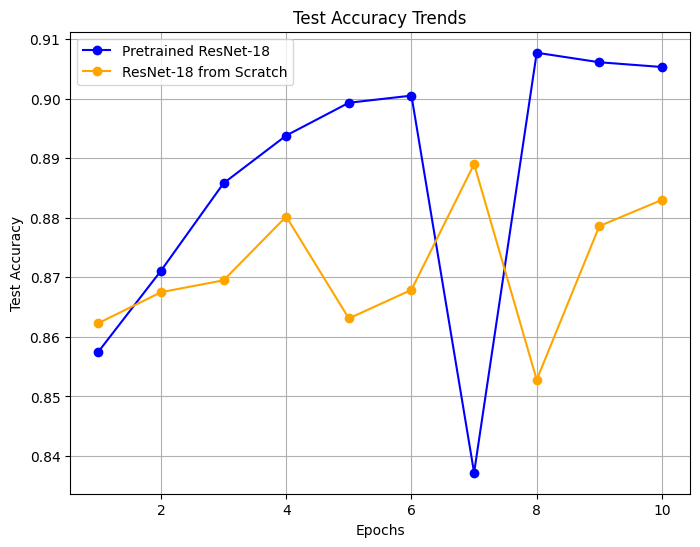

In [ ]:
#ResNet Evaluation from scratch and pretrained model :
pretrained_test_acc = [0.8575, 0.8711, 0.8858, 0.8938, 0.8993, 0.9005, 0.8372, 0.9077, 0.9061, 0.9053]
scratch_test_acc = [0.8623, 0.8675, 0.8695, 0.8802, 0.8631, 0.8679, 0.8890, 0.8528, 0.8786, 0.8830]

epochs = range(1, len(pretrained_test_acc) + 1)

plt.figure(figsize=(8, 6))
plt.plot(epochs, pretrained_test_acc, marker='o', linestyle='-', color='blue', label='Pretrained ResNet-18')
plt.plot(epochs, scratch_test_acc, marker='o', linestyle='-', color='orange', label='ResNet-18 from Scratch')

plt.title('Test Accuracy Trends')
plt.xlabel('Epochs')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
resnet_save_path = "/content/drive/MyDrive/machine_learning_project/model/resnet_model_checkpoint.pth"
resnet_pretrained_save_path = "/content/drive/MyDrive/machine_learning_project/model/resnet_pretrained_model_checkpoint.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


def get_predictions(model, dataloader):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

num_classes = 2

pretrained_checkpoint = torch.load(resnet_pretrained_save_path, map_location=device)
resnet18_pretrained_model.load_state_dict(pretrained_checkpoint['model_state_dict'])
resnet18_pretrained_model.eval()


preds_pretrained, labels_pretrained = get_predictions(resnet18_pretrained_model, test_loader_resnet)
conf_matrix_pretrained = confusion_matrix(labels_pretrained, preds_pretrained)

print("\nConfusion Matrix for Pretrained ResNet Model:")
print(conf_matrix_pretrained)


cuda


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Confusion Matrix for ResNet Model from Scratch:

Confusion Matrix for Pretrained ResNet Model:
[[1312   89]
 [ 149  963]]


In [ ]:
checkpoint = torch.load(resnet_save_path, map_location=device)
resnet18_model.load_state_dict(checkpoint['model_state_dict'])
resnet18_model.eval()

preds_resnet, labels_resnet = get_predictions(resnet18_model, test_loader_resnet)

conf_matrix_resnet = confusion_matrix(labels_resnet, preds_resnet)

print("Confusion Matrix for ResNet Model from Scratch:")
print(conf_matrix_resnet)


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Confusion Matrix for ResNet Model from Scratch:
[[1374   27]
 [ 267  845]]


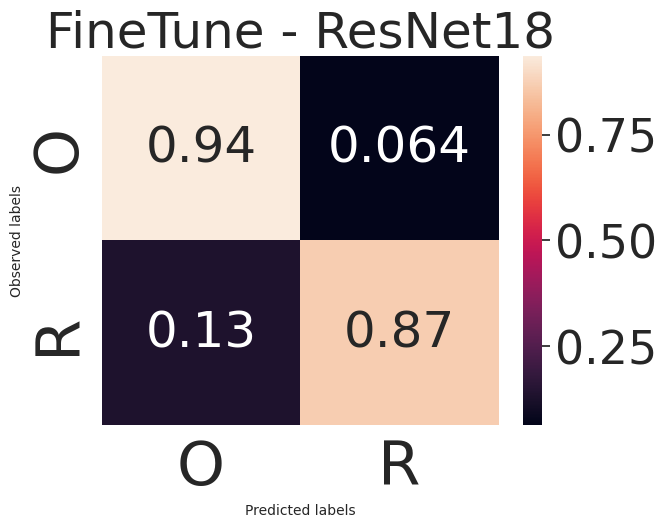

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
confusion_matrix(preds_pretrained, labels_pretrained)

df_cm = pd.DataFrame(conf_matrix_pretrained/ np.sum(conf_matrix_pretrained, axis=1)[:, None], index = [i for i in class_names],
                     columns = [i for i in class_names])
ax = plt.subplot()
sns.set(font_scale=3.0)
sns.heatmap(df_cm, annot=True)

label_font = {'size':'10'}
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);
ax.set_title('FineTune - ResNet18');
plt.show()

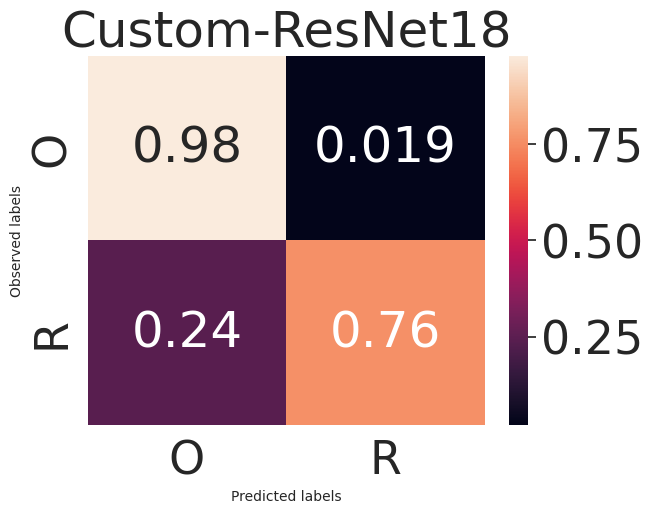

In [ ]:
df_cm = pd.DataFrame(conf_matrix_resnet/ np.sum(conf_matrix_resnet, axis=1)[:, None], index = [i for i in class_names],
                     columns = [i for i in class_names])
ax = plt.subplot()
sns.set(font_scale=3.0)
sns.heatmap(df_cm, annot=True)
label_font = {'size':'10'}
ax.set_xlabel('Predicted labels', fontdict=label_font);
ax.set_ylabel('Observed labels', fontdict=label_font);
ax.set_title('Custom-ResNet18');

plt.show()

In [ ]:
precision = conf_matrix_resnet[0, 0] / (conf_matrix_resnet[0, 0] + conf_matrix_resnet[0, 1])

recall = conf_matrix_resnet[0, 0] / (conf_matrix_resnet[0, 0] + conf_matrix_resnet[1, 0])

# Calculate the F1 score
f1_score = 2 * precision * recall / (precision + recall)

print('Precision:', precision)
print('Recall:', recall)
print('F1 score:', f1_score)

Precision: 0.9807280513918629
Recall: 0.8372943327239488
F1 score: 0.9033530571992111


In [ ]:
precision = conf_matrix_pretrained[0, 0] / (conf_matrix_pretrained[0, 0] + conf_matrix_pretrained[0, 1])

recall = conf_matrix_pretrained[0, 0] / (conf_matrix_pretrained[0, 0] + conf_matrix_pretrained[1, 0])

f1_score = 2 * precision * recall / (precision + recall)

print('Precision Pretrained:', precision)
print('Recall Pretrained:', recall)
print('F1 score Pretrained:', f1_score)

Precision Pretrained: 0.9364739471805853
Recall Pretrained: 0.8980150581793293
F1 score Pretrained: 0.9168413696715584


                Models  Precision  Recall  F1-Score  Accuracy
0      Custom-ResNet18         98      83        90        87
1  Fine-tuned-Resnet18         93      89        91        89


<Axes: title={'center': 'Evaluation Metrics'}, xlabel='Models'>

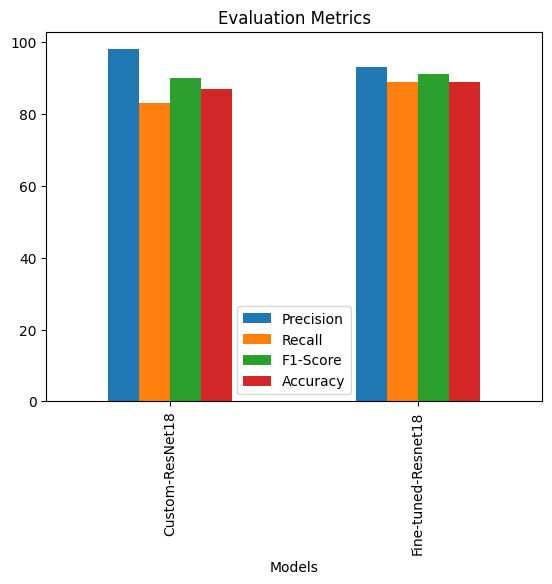

In [ ]:
df = pd.DataFrame([['Custom-ResNet18', 98, 83, 90, 88], ['Fine-tuned-Resnet18', 93, 89, 91, 89]],
                  columns=['Models', 'Precision', 'Recall', 'F1-Score', 'Accuracy'])
print(df)
df.plot(x='Models',kind='bar',stacked=False, title='Evaluation Metrics')


In [ ]:
#resnet_pretrained_train_accuracy = [0.8193, 0.8335, 0.8545, 0.8622, 0.8702, 0.8965, 0.8818, 0.8861, 0.8893, 0.8956]
#pretrained_test_acc = [0.8575, 0.8711, 0.8858, 0.8938, 0.8993, 0.9005, 0.8372, 0.9077, 0.9061, 0.9053]
#resnet_scratch_train_accuracy = [0.8173, 0.8196, 0.8210, 0.8523, 0.8180, 0.8126, 0.8588, 0.8003, 0.8437,8556]
#scratch_test_acc = [0.8623, 0.8675, 0.8695, 0.8802, 0.8631, 0.8679, 0.8890, 0.8528, 0.8786, 0.8830]
